## Name: Paul Hickey

## Student ID: 22267964

- The first goal of e-tivity 5 is to understand how to introduce dimensionality reduction techniques into the training pipeline. This time we will use regression algorithms (i.e., algorithms for numeric prediction) instead of classifiers, but the same dimensionality reduction techniques can be used in classification pipelines. 
- The second goal of this e-tivity is to practice training regression models.

# Tasks
- Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv.
- Draw conclusions from the results you observe in a markdown cell. 
- Add a third regression algorithm of your choice. 
- Describe how it compares to Random Forest and Linear regression in a markdown cell (max 250 words in a markdown cell).

---

- Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. 
- Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. 
- Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).

# 1. Import modules & data

In [315]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For additional models
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

# Suppress convergence warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Additional dimensionality reduction
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FactorAnalysis
from sklearn.feature_selection import SelectFromModel

In [316]:
df = pd.read_csv("./insurance.csv")

In [317]:
# Make a copy of the data
df_orig = df.copy(deep=True)

# 2. EDA

In [318]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [319]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

From an initial look at the dataset, we can see that we will be using regression to predict insurance costs based on the set of available features.

## Check for missing values

In [320]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

Based on the above, there are no obviously missing values in the data.

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Assign numeric and categorical labels to groups for ease of access

In [322]:
numeric = df.select_dtypes(['int64', 'float64']).columns.values
categorical = df.select_dtypes(['object']).columns.values

## Explore the numeric data

In [323]:
df[numeric].describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

The values above, for the most part appear acceptable. The one feature that bears further investigation is **bmi** (body mass index), which *"is a measure that uses your height and weight to work out if your weight is healthy"* ([source](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/)).

According to the NHS, BMI measurements can be interpreted as follows:
- below 18.5 – you're in the underweight range
- between 18.5 and 24.9 – you're in the healthy weight range
- between 25 and 29.9 – you're in the overweight range
- 30 or over – you're in the obese range

A number of resources assign additional categorisations into the 50+ range, so we can assume that the maximum value of 53.13 is an acceptable data point.

In [324]:
df[numeric].var()

age               1.974014e+02
bmi               3.718788e+01
children          1.453213e+00
insurance_cost    1.466524e+08
dtype: float64

From the above we can also see that there are no numeric variables with very low relative variance. The **insurance_cost** feature has a high relative variance, so we might expect to encounter some outliers within it.

In [325]:
def plotFeatureDists(feature, histBins):
    fig, axs =  plt.subplots(nrows=1, ncols=3, figsize = (9,4))

    # Histogram for distribution
    axs[0].hist(df[feature], bins=histBins, edgecolor='white')
    axs[0].set_title(feature.title(), fontsize=14)
    
    # Violin plot
    sns.violinplot(data=df, y=feature, ax=axs[1], split=False)
    axs[1].set_title(feature.title(), fontsize=16)

    # Boxplot
    sns.boxplot(data=df, y=feature, ax=axs[2])
    axs[2].set_title(feature.title(), fontsize=16)

    plt.tight_layout(pad=1.5)
    plt.show()

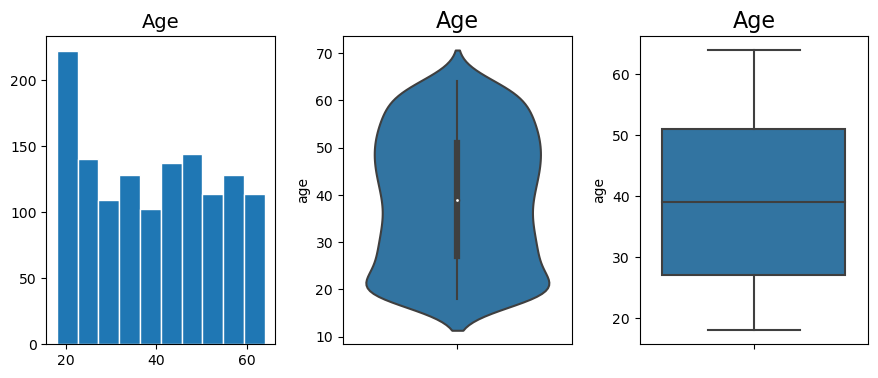

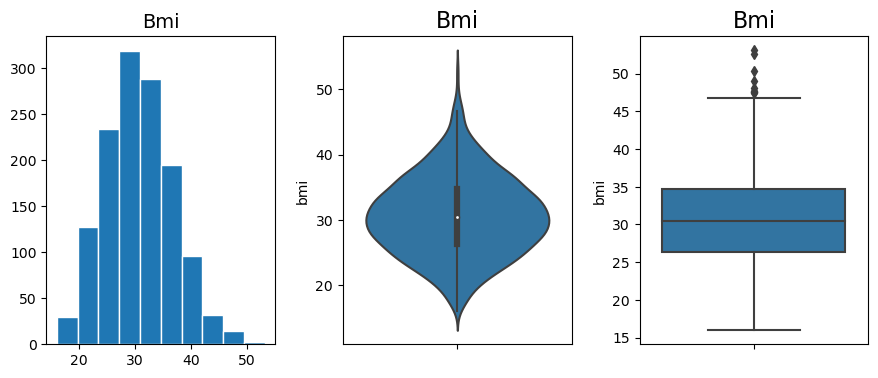

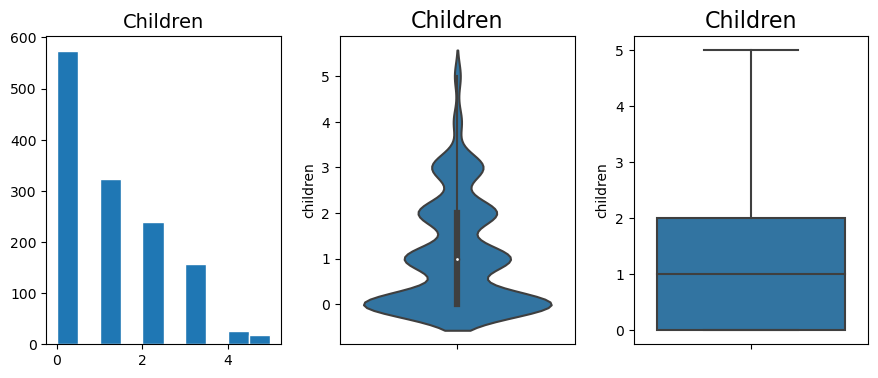

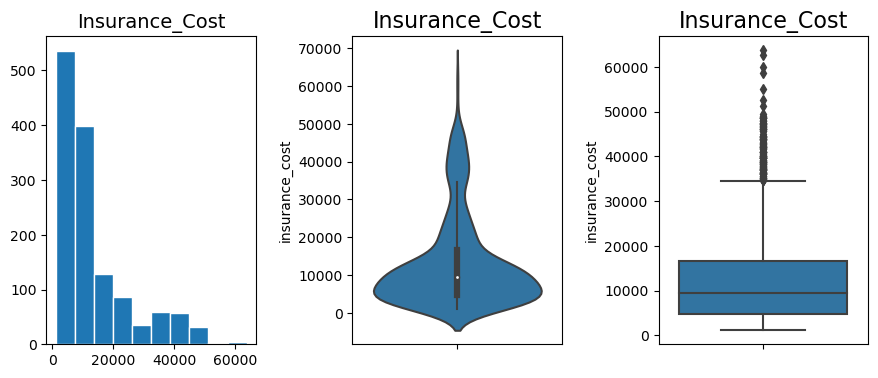

In [326]:
for feature in numeric:
    plotFeatureDists(feature, 10)

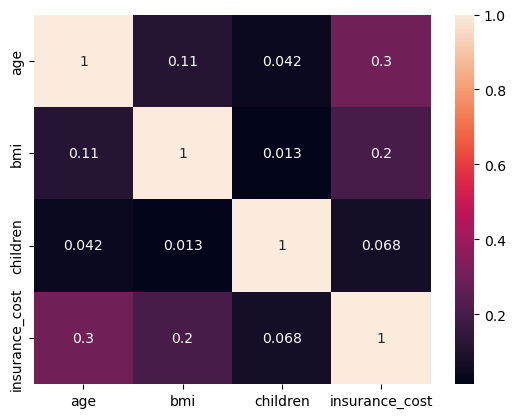

In [327]:
# correlation matrix for numerical features
sns.heatmap(df[numeric].corr(), annot=True);

From the plot above, we can see that theres is some slight correlation between **age** and **insurance_cost** and, to a lesser extent between **bmi** and **insurance_cost**.

As we aren't dealing with too many categorical features, we can have a quick look at how they are distributed in respect of the numeric features.

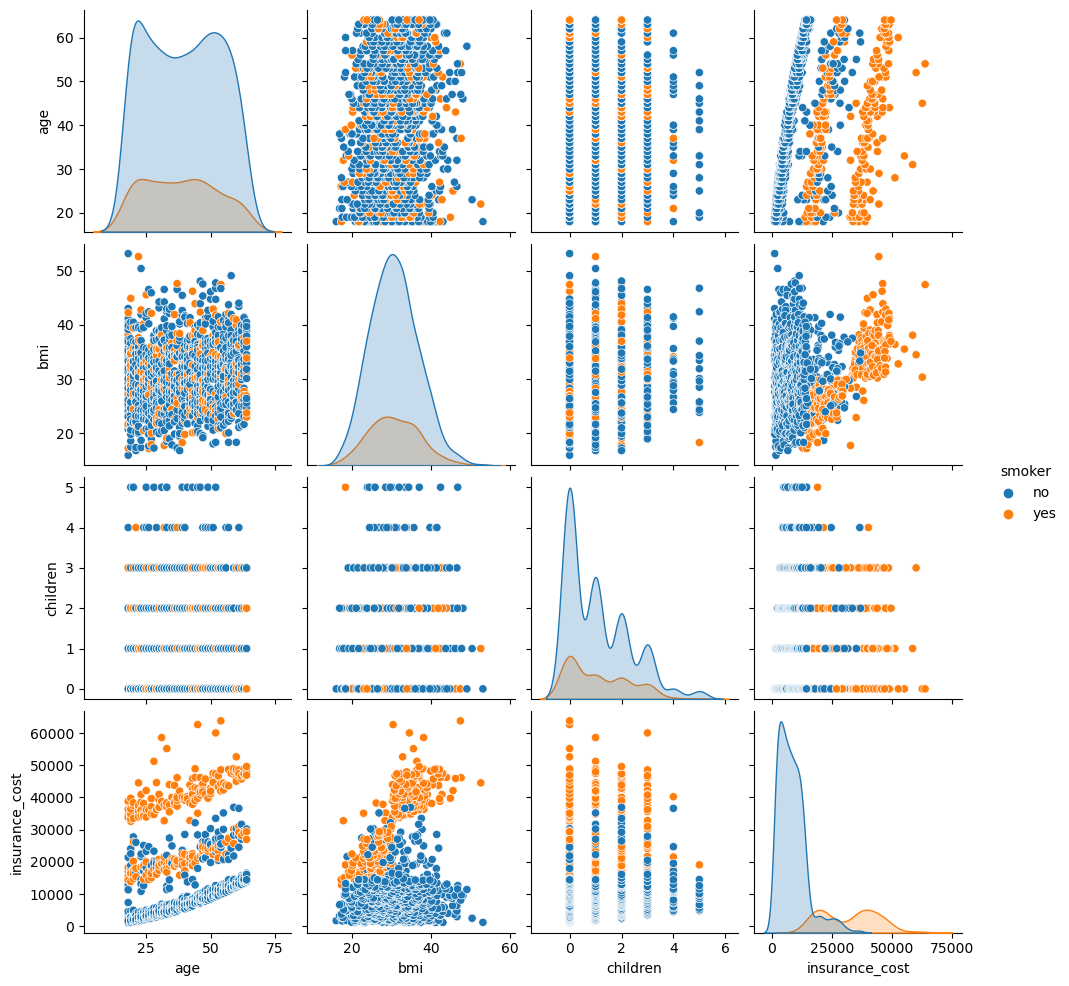

In [328]:
sns.pairplot(data=df, hue='smoker')
plt.show()

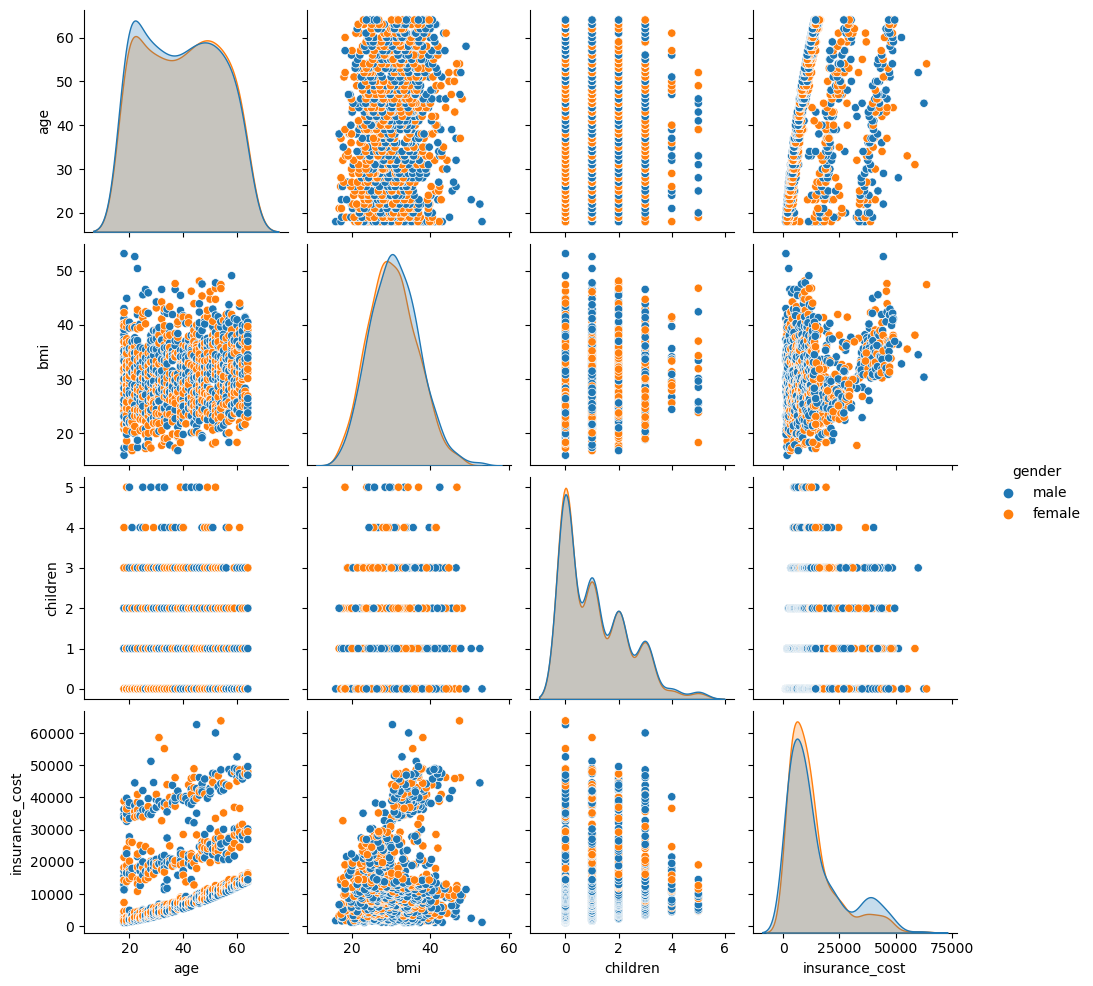

In [329]:
sns.pairplot(data=df, hue='gender')
plt.show()

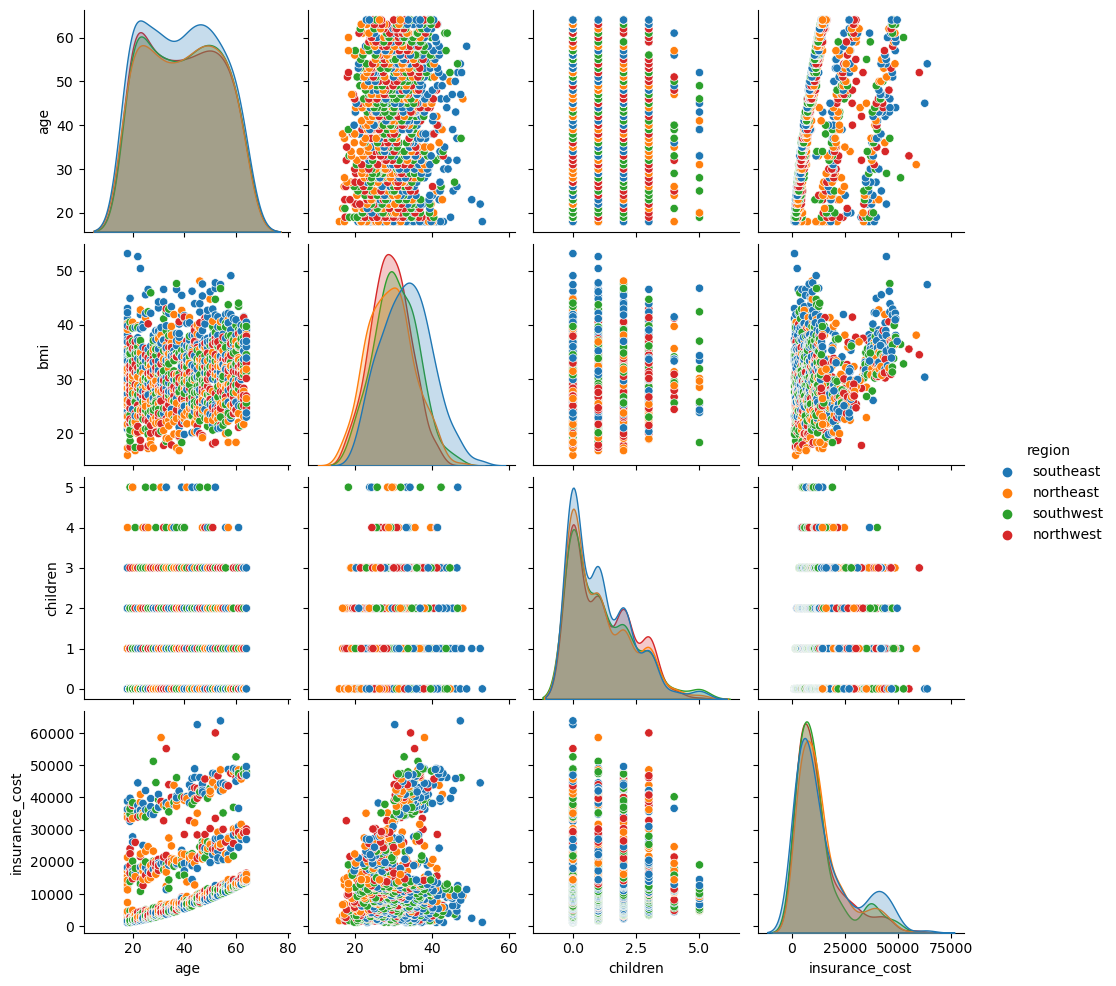

In [330]:
sns.pairplot(data=df, hue='region')
plt.show()

From the above plots, we can see that the **smoker** feature has a significant influence on insurance costs.

## Explore the categorical data

In [331]:
df[categorical].describe()

gender smoker     region
count    1338   1338       1338
unique      2      2          4
top      male     no  southeast
freq      676   1064        364

In [332]:
for col in categorical:
    print(f'Feature: {col} \n Values: {df[col].unique()}')
    print('--------------------------------')

Feature: gender 
 Values: ['male' 'female']
--------------------------------
Feature: smoker 
 Values: ['no' 'yes']
--------------------------------
Feature: region 
 Values: ['southeast' 'northeast' 'southwest' 'northwest']
--------------------------------


We can confirm from the above that the dataset has no unexpected missing values under the categorical features.

# 4. Data preparation
We can start by onehot encoding the categorical features.

In [333]:
df = pd.get_dummies(df, columns=categorical, drop_first=True, dtype=int)

In [334]:
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes   
0   18  33.770         1      1725.55230            1           0  \
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

In [335]:
y_label = 'insurance_cost'

In [336]:
# store a list with the names of all predictors
col_names = [col for col in df if col not in [y_label]]

In [337]:
# define column groups with same data preparation
names_outliers = ['bmi']
names_no_outliers = list(set(col_names) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns.

In [338]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [339]:
 class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

We can now build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with FeatureUnion.

In [340]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=col_names),
    FeatureUnion(transformer_list=[
        ('outlier_columns', make_pipeline(
            ColumnSelector(columns=names_outliers),
            RobustScaler()
        )),
        ('no_outlier_columns', make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into target and predictors and split the dataset into a training and test sets.

In [341]:
y = df[y_label]
X = df.drop(y_label, axis=1).values

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 5. Find optimal models
## Grid search for best parameters and best dimensionality reduction method
Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

In [343]:
# Add warning suppression for convergence warnings
# @ignore_warnings(category=ConvergenceWarning)
def generatePipeline(pipe, param_grid, X_train, y_train):
    
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
        
    search.fit(X_train, y_train)
    print("Best CV score = %0.3f:" % search.best_score_)
    print("Best parameters: ", search.best_params_)

    # store the best params and best model for later use
    outputs = {
        'best_params': search.best_params_,
        'best_model': search.best_estimator_
    }
    
    return outputs

### Random Forest Pipeline
The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [344]:
rf_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [166]:
N_FEATURES_OPTIONS = [2, 3, 5, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

rf_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

In [167]:
rf_model = generatePipeline(rf_pipe, rf_param_grid, X_train, y_train)

Best CV score = 0.845:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'regresson__max_depth': 4}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [168]:
lr_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [169]:
N_FEATURES_OPTIONS = [2, 3, 5, 8]

lr_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    }  
]

In [170]:
lr_model = generatePipeline(lr_pipe, lr_param_grid, X_train, y_train)

Best CV score = 0.731:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## Compare regression models on test set
Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [171]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [172]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, rf_model['best_model'])
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, lr_model['best_model'])

We will use a Pandas bar plots to compare the results. 

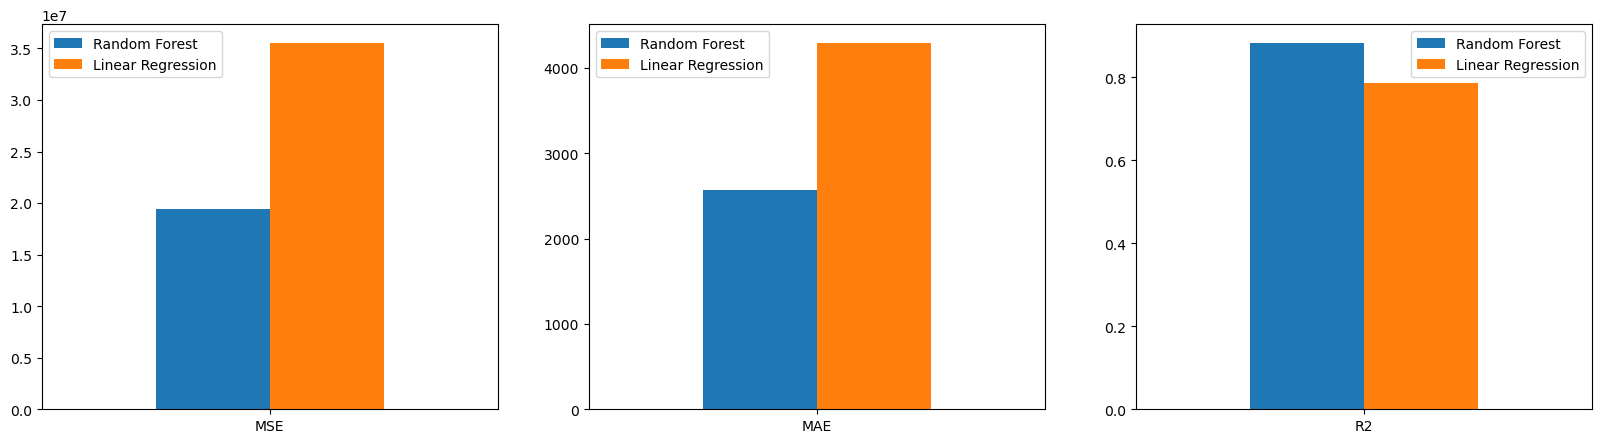

In [174]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

The plots confirm that Random Forest is the better regression model on this data, with lower mean squared error and mean absolute error, as well as a higher R2 score.

# 6. Add additional regression models

## SGD pipeline

In [208]:
sgd_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('sgd_reg', SGDRegressor(loss='squared_error', max_iter=1000, tol=1e-3, penalty='elasticnet'))])

In [209]:
N_FEATURES_OPTIONS = (2, 3, 4, 5, 8)
alpha_options = np.logspace(-4, -2, num=30)
epsilon = (0.1, 0.25, 0.5)

sgd_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'sgd_reg__alpha': alpha_options,
        'sgd_reg__epsilon': epsilon
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'sgd_reg__alpha': alpha_options,
        'sgd_reg__epsilon': epsilon 
    }  
]

In [210]:
sgd_model = generatePipeline(sgd_pipe, sgd_param_grid, X_train, y_train)

Best CV score = 0.732:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'sgd_reg__alpha': 0.008531678524172805, 'sgd_reg__epsilon': 0.25}


In [211]:
# Evaluate model
SGD_mse, SGD_mae, SGD_r2 = evaluate_model(X_test, y_test, sgd_model['best_model'])

## Decision tree regression pipeline
Given the relatively poor performance of the SGD model, we will also train a Decision Tree regression model to see if we can achieve results similar to Random Forest.

In [212]:
dt_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('dt_reg', DecisionTreeRegressor())])

In [217]:
N_FEATURES_OPTIONS = [2, 3, 4, 5, 8]

criteria = ['squared_error', 'friedman_mse', 'poisson']
min_samples = [2, 3]
max_features = ['sqrt', 'log2', None]
max_depth = [2, 4, 6, 8]

dt_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'dt_reg__criterion': criteria,
        'dt_reg__min_samples_split': min_samples,
        'dt_reg__max_features': max_features,
        'dt_reg__max_depth': max_depth,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'dt_reg__criterion': criteria,
        'dt_reg__min_samples_split': min_samples,
        'dt_reg__max_features': max_features,
        'dt_reg__max_depth': max_depth,  
    }  
]

In [218]:
dt_model = generatePipeline(dt_pipe, dt_param_grid, X_train, y_train)

Best CV score = 0.839:
Best parameters:  {'dt_reg__criterion': 'poisson', 'dt_reg__max_depth': 4, 'dt_reg__max_features': None, 'dt_reg__min_samples_split': 2, 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}


In [219]:
# Evaluate model
DT_mse, DT_mae, DT_r2 = evaluate_model(X_test, y_test, dt_model['best_model'])

### Compare all models

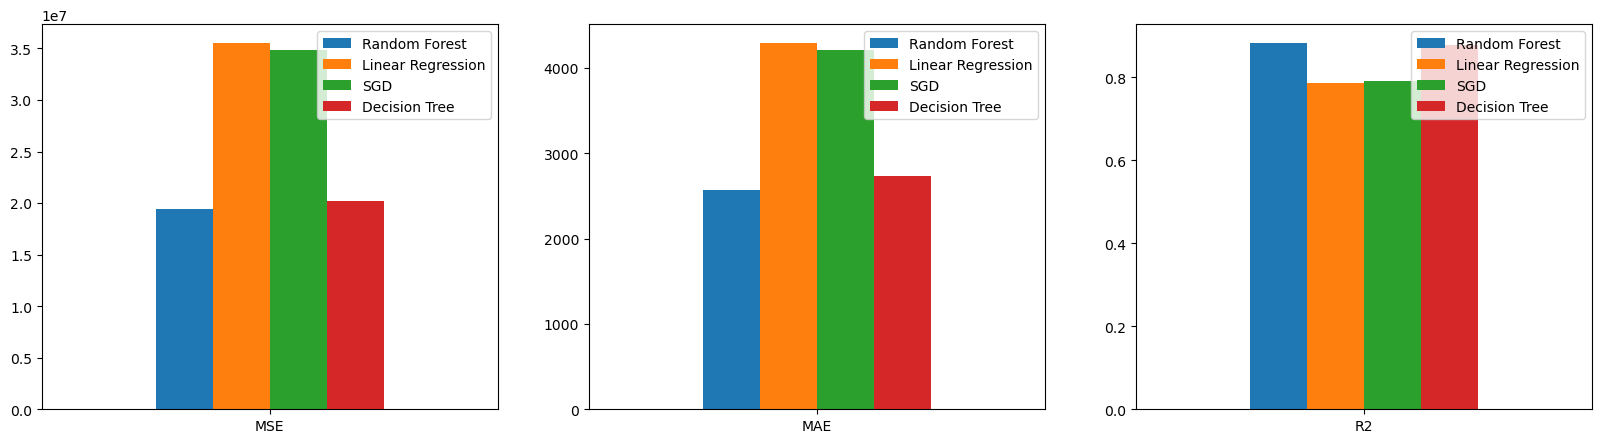

In [226]:
model_names = ['Random Forest', 'Linear Regression', 'SGD', 'Decision Tree']
mse_props = {model_names[0]: RF_mse, model_names[1]: LR_mse, model_names[2]: SGD_mse, model_names[3]: DT_mse}
mae_props = {model_names[0]: RF_mae, model_names[1]: LR_mae, model_names[2]: SGD_mae, model_names[3]: DT_mae}
r2_props = {model_names[0]: RF_r2, model_names[1]: LR_r2, model_names[2]: SGD_r2, model_names[3]: DT_r2}

df_mse = pd.DataFrame(mse_props, index=['MSE'])
df_mae = pd.DataFrame(mae_props, index=['MAE'])
df_r2 = pd.DataFrame(r2_props, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [244]:
results = (mse_props, mae_props, r2_props)
comparison = pd.DataFrame(results, index=['MSE', 'MAE', 'R2 Score'])
comparison

Random Forest  Linear Regression           SGD  Decision Tree
MSE        1.940450e+07       3.556349e+07  3.489344e+07   2.023777e+07
MAE        2.571271e+03       4.295091e+03  4.205032e+03   2.727062e+03
R2 Score   8.832585e-01       7.860426e-01  7.900738e-01   8.782453e-01

## Observations
The plots and table of results above confirm that `Random Forest` is still the better performing regression model on this data, with lower mean squared error and mean absolute error, as well as a higher R2 score. It is however not too far ahead of the Decision Tree model.

The `Stochastic Gradient Descent` model, which we have tried also, performs significantly less effectively and is not much better than the ordinary least squares, `Linear Regression` model.

`MSE` and `MAE` are error measures based on the distance between the predicted and actual values. `R2` score (in the range [0,1]) is based on the ratio of the variance and the variance explained by the data, where 1 implies perfect correlation.

# 7. Additional dimensionality reduction techniques

As the Random Forest model showed the best performance on the data, we'll apply the additional dimensionality reduction techniques to it and see if we can improve the final model.

In [286]:
rf_new_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [ ]:
criteria = ['squared_error', 'friedman_mse', 'poisson']
min_samples = [2, 3]
max_features = ['sqrt', 'log2', None]
max_depth = [2, 4, 6, 8]

dt_param_grid = [
    {
        
        
    },

In [304]:
# RF params
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

n_components = [2, 3, 5, 8]
iterated_power = [3, 4, 5]
kernel = ['rbf', 'cosine']
gamma = np.logspace(-4, -3, num=50)

# DT feature-selector
criteria = ['squared_error', 'friedman_mse', 'poisson']
min_samples = [2, 3]
max_features = ['sqrt', 'log2', None]

rf_new_param_grid = [ 
    {
        'reduce_dim': [KernelPCA()],
        'reduce_dim__n_components': n_components,
        'reduce_dim__kernel': kernel,
        'reduce_dim__gamma': gamma,
        'reduce_dim__n_components': n_components,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': n_components,
        'reduce_dim__iterated_power': iterated_power,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
     
    },
    {
        'reduce_dim': [SelectFromModel(estimator=DecisionTreeRegressor(criterion='poisson', max_features='log2'))],
        'reduce_dim__max_features': n_components,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

In [305]:
rf_new_model = generatePipeline(rf_new_pipe, rf_new_param_grid, X_train, y_train)

Best CV score = 0.843:
Best parameters:  {'reduce_dim': SelectFromModel(estimator=DecisionTreeRegressor(criterion='poisson',
                                                max_features='log2'),
                max_features=5), 'reduce_dim__max_features': 5, 'regresson__max_depth': 4}


In [308]:
# Evaluate model
RF_NEW_mse, RF_NEW_mae, RF_NEW_r2 = evaluate_model(X_test, y_test, rf_new_model['best_model'])

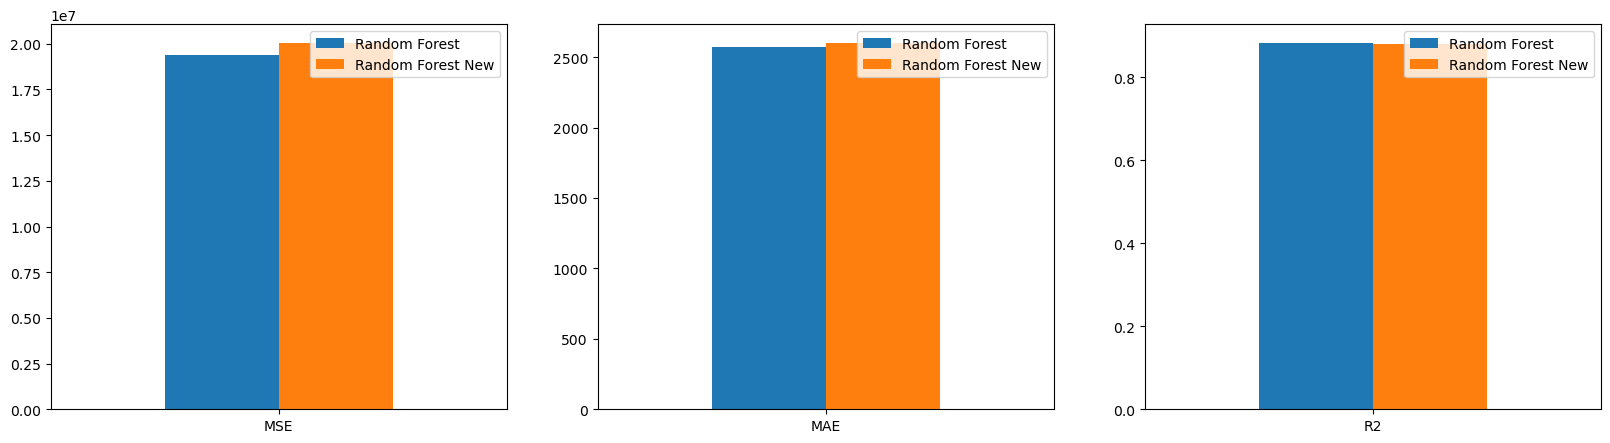

In [309]:
mse_props = {'Random Forest': RF_mse, 'Random Forest New': RF_NEW_mse}
mae_props = {'Random Forest': RF_mae, 'Random Forest New': RF_NEW_mae}
r2_props = {'Random Forest': RF_r2, 'Random Forest New': RF_NEW_r2}

df_mse = pd.DataFrame(mse_props, index=['MSE'])
df_mae = pd.DataFrame(mae_props, index=['MAE'])
df_r2 = pd.DataFrame(r2_props, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [313]:
results_2 = (mse_props, mae_props, r2_props)
comparison = pd.DataFrame(results_2, index=['MSE', 'MAE', 'R2 Score'])
comparison

Random Forest  Random Forest New
MSE        1.940450e+07       2.006598e+07
MAE        2.571271e+03       2.603934e+03
R2 Score   8.832585e-01       8.792789e-01

# 8. Conclusions
As we can see, across all metrics, the `Random Forest` model using `Recursive Feature Elimination` performed best. What is most notable is that feature selection techniques yielded better perfomances in both final models than decomposition approaches, with promising results from the `SelectFromModel` feature selection technique.

In the dimensionality reduction techniques applied above, `Factor Analysis` (FA) is similar to `PCA` (and the non-linear `KernelPCA`) in that it seeks to discover latent variables from relationships between the observed variables, where they differ significantly in respect to this is that the components discovered by PCA are a linear combination of the observed variables, whereas in FA, the observed variables are linear combinations of the latent variables (factors).

Below we can see the best dimensionality reduction techniques and settings that (combined with the Random Forest's own max_depth parameter) led to the models above.

## Best performing (original) model

In [310]:
rf_model['best_params']

{'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8),
 'reduce_dim__n_features_to_select': 8,
 'regresson__max_depth': 4}

## New model

In [311]:
rf_new_model['best_params']

{'reduce_dim': SelectFromModel(estimator=DecisionTreeRegressor(criterion='poisson',
                                                 max_features='log2'),
                 max_features=5),
 'reduce_dim__max_features': 5,
 'regresson__max_depth': 4}

## Train a Final Model
Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [345]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     rf_model['best_params'].get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(rf_model['best_params'], 'regresson__')))

final_model = pipe.fit(X, y)

In [346]:
# Save model to disk
filename = 'rf_insurance_model.sav'
pickle.dump(final_model, open(filename, 'wb'))